In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os, sys
%matplotlib inline

os.chdir('..\..\..\..')

# from input_configuration import base_year
import toml
config = toml.load(os.path.join(os.getcwd(), 'configuration/input_configuration.toml'))

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
working_dir = r'outputs/agg/dash'
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

In [3]:
def load_data(fname):
    """ open and join model and survey data """

    df_model = pd.read_csv(os.path.join(working_dir,fname+'.csv'))
    df_model['source'] = 'model'
    df_survey = pd.read_csv(os.path.join(working_dir,'survey',fname+'.csv'))
    df_survey['source'] = 'survey'
    df = df_model.append(df_survey)

    return df

In [4]:
parcel_geog = pd.read_sql_table('parcel_'+config['base_year']+'_geography', 'sqlite:///inputs/db/soundcast_inputs.db',
        columns=['CountyName','ParcelID'])

# Usual Work Distance

In [5]:
person = pd.read_csv(r'outputs/daysim/_person.tsv', delim_whitespace=True)
person_survey = pd.read_csv(r'inputs/base_year/survey/_person.tsv', delim_whitespace=True)

person['source'] = 'model'
person_survey['source'] = 'survey'

In [6]:
person = person.append(person_survey)
person = person.merge(parcel_geog, left_on='pwpcl', right_on='ParcelID', how='left')

In [7]:
person['wt_pwautime'] = person['pwautime']*person['psexpfac']
person['wt_pwaudist'] = person['pwaudist']*person['psexpfac']

Average Distance for **All Workers** Not Working at Home (weighted for survey)

In [8]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    10.89
survey   10.56
dtype: float64

Average Distance by Work County

In [9]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,11.63,10.65
Kitsap,10.29,7.48
Pierce,9.50,9.93
Snohomish,9.22,11.93


Average for **Full-Time** Workers only

In [10]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0) & (person['pwtyp'] == 1)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    11.82
survey   11.44
dtype: float64

In [11]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,12.49,11.83
Kitsap,11.39,8.28
Pierce,10.41,11.47
Snohomish,10.24,10.77


Average for **Part-Time** Workers Only

In [12]:
df = person[(person['pwtaz'] > 0) & (person['pwaudist'] > 0) & (person['pwtyp'] == 1)]
df.groupby('source').sum()['wt_pwaudist']/df.groupby('source').sum()['psexpfac']

source
model    11.82
survey   11.44
dtype: float64

In [13]:
df1 = df.groupby(['CountyName', 'source']).sum()[['wt_pwaudist']]
df2 = df.groupby(['CountyName', 'source']).sum()[['psexpfac']]
_df = df1.merge(df2, left_index=True, right_index=True)
_df = pd.DataFrame(_df['wt_pwaudist']/_df['psexpfac'])
_df.pivot_table(index='CountyName', columns='source', values=0, aggfunc='sum')

source,model,survey
CountyName,,
King,12.49,11.83
Kitsap,11.39,8.28
Pierce,10.41,11.47
Snohomish,10.24,10.77


## Trip Length Distribution (miles)
Percent of Total, bins of 1 mile up to 60 miles

All Workers

<AxesSubplot:xlabel='pwaudist_bin'>

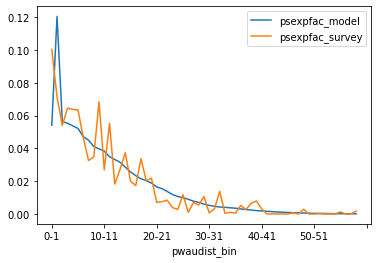

In [14]:
# Create bins
max_bin = 60
person['pwaudist_bin'] = pd.cut(person['pwaudist'], bins=range(0,max_bin), labels=[str(i)+'-'+str(i+1) for i in range(0,max_bin-1)])
df1 = person[(person['source'] == 'model') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot()

Bins of 5 miles, up to 50 miles

<AxesSubplot:xlabel='pwaudist_bin'>

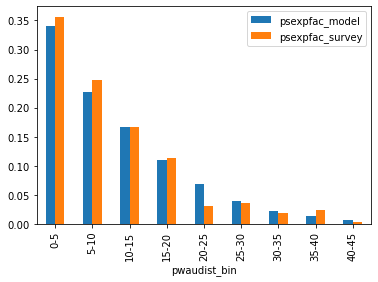

In [15]:
# Create bins
max_bin = 50
person['pwaudist_bin'] = pd.cut(person['pwaudist'], bins=range(0,max_bin,5), labels=[str(i*5)+'-'+str((i+1)*5) for i in range(0,9)])
df1 = person[(person['source'] == 'model') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df2 = person[(person['source'] == 'survey') & (person['pwaudist'] <= max_bin) & (person['pwaudist'] > 0)]
df1 = df1.groupby('pwaudist_bin').sum()[['psexpfac']]/df1['psexpfac'].sum()
df2 = df2.groupby('pwaudist_bin').sum()[['psexpfac']]/df2['psexpfac'].sum()
df = df1.merge(df2, left_index=True, right_index=True, suffixes=['_model','_survey'])
df.plot(kind='bar')

### Percent of Workers with <1 Mile and >20 Mile Commutes

In [16]:
pd.options.display.float_format = '{:,.1%}'.format

_df_tot = person[person['pwaudist'] > 0].groupby('source').sum()[['psexpfac']].T

_df_1 = person[(person['pwaudist'] < 1) & (person['pwaudist'] > 0)].groupby('source').sum()[['psexpfac']].T
_df_1 = _df_1/_df_tot
_df_1.index = ['< 1 mile']

_df_20 = person[(person['pwaudist'] > 20)].groupby('source').sum()[['psexpfac']].T
_df_20 = _df_20/_df_tot
_df_20.index = ['> 20 miles']

_df = _df_1.append(_df_20).reset_index()
_df.rename(columns={'index': 'Commute Range'}, inplace=True)
_df = _df.rename_axis(None, axis=1)
_df

,Commute Range,model,survey
0,< 1 mile,5.4%,10.0%
1,> 20 miles,15.8%,12.1%


<AxesSubplot:xlabel='Commute Range'>

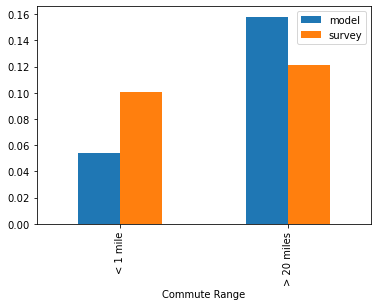

In [17]:
_df.set_index('Commute Range').plot(kind='bar',)

### Average Commute Distance by Gender

In [18]:
pd.options.display.float_format = '{:0,.2f}'.format
df = person[(person['pwaudist'] > 0) & (person['pgend'].isin([1,2]))]
_df = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='pgend', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df['pgend'] = df['pgend'].map({1: 'Male',2:'Female'})
df.rename(columns={'pgend': 'Gender'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

,Gender,model,survey
0,Male,11.75,11.48
1,Female,9.83,9.05


<AxesSubplot:xlabel='Gender'>

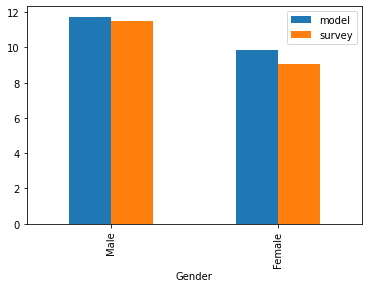

In [19]:
df.set_index('Gender').plot(kind='bar')

### Average Commute Distance by Age

In [20]:
person['age_cat'] = pd.cut(person['pagey'], bins=[0,30,50,64,100], labels=['<29','30-49','50-65','65+'])
df = person[(person['pwaudist'] > 0)]
_df = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='wt_pwaudist')
_df_tot = df.pivot_table(index='age_cat', columns='source', aggfunc='sum', values='psexpfac')
df = _df/_df_tot
df = df.reset_index()
df.rename(columns={'age_cat': 'Age Category'}, inplace=True)
df = df.rename_axis(None, axis=1)
df

,Age Category,model,survey
0,<29,9.71,9.06
1,30-49,11.19,11.45
2,50-65,11.77,10.82
3,65+,10.08,10.67


<AxesSubplot:xlabel='Age Category'>

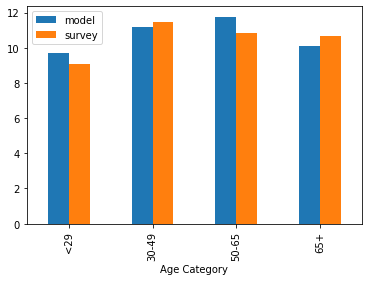

In [21]:
df.set_index('Age Category').plot(kind='bar')

## County to County Work Flows

All Workers

Model Results 

In [22]:
df = load_data(r'work_flows')
pd.options.display.float_format = '{:0,.0f}'.format
df.rename(columns={'person_county': 'Home County', 'person_work_county':'Work County'}, inplace=True)

df_model = pd.pivot_table(df[df['source'] == 'model'], index='Home County', columns='Work County', aggfunc='sum')
df_model['Total'] = df_model.sum(axis=1)
df_model.loc['Total',:] = df_model.sum(axis=0)
df_model

psexpfac                               Total
Work County      King  Kitsap  Pierce Snohomish          
Home County                                              
King        1,141,094   3,627  43,558    39,687 1,227,966
Kitsap         12,973 104,345   4,500       191   122,009
Pierce        104,025  10,378 288,085       589   403,077
Snohomish     150,143   1,088     836   264,232   416,299
Total       1,408,235 119,438 336,979   304,699 2,169,351

Survey Results

In [23]:
df_survey = pd.pivot_table(df[df['source'] == 'survey'], index='Home County', columns='Work County', aggfunc='sum')
df_survey['Total'] = df_survey.sum(axis=1)
df_survey.loc['Total',:] = df_survey.sum(axis=0)
df_survey

psexpfac                               Total
Work County      King  Kitsap  Pierce Snohomish          
Home County                                              
King        2,924,119     213  62,917   166,116 3,153,365
Kitsap         28,296 249,357   3,199       NaN   280,852
Pierce        246,958   2,882 916,246       223 1,166,310
Snohomish     181,779      74   2,798   475,020   659,671
Total       3,381,152 252,527 985,161   641,359 5,260,198

Total Difference (Model - Survey)

In [24]:
df_model-df_survey

psexpfac                                  Total
Work County       King   Kitsap   Pierce Snohomish           
Home County                                                  
King        -1,783,025    3,414  -19,359  -126,429 -1,925,399
Kitsap         -15,323 -145,012    1,301       NaN   -158,843
Pierce        -142,933    7,496 -628,161       366   -763,233
Snohomish      -31,636    1,014   -1,962  -210,788   -243,372
Total       -1,972,917 -133,089 -648,182  -336,660 -3,090,847

Percent Difference (Relative to Survey)

In [25]:
((df_model-df_survey)/df_survey).applymap(format_percent)

psexpfac                                  Total
Work County     King     Kitsap   Pierce Snohomish         
Home County                                                
King         -60.98%  1,602.28%  -30.77%   -76.11%  -61.06%
Kitsap       -54.15%    -58.15%   40.67%      nan%  -56.56%
Pierce       -57.88%    260.04%  -68.56%   164.44%  -65.44%
Snohomish    -17.40%  1,372.60%  -70.13%   -44.37%  -36.89%
Total        -58.35%    -52.70%  -65.79%   -52.49%  -58.76%